# 03 KPI Analysis & Visualizations - Gazelle/Pon Case

**Doel**: 
- Calculate comprehensive market KPIs by gemeente/provincie
- Generate visualizations
- Create insights for strategic questions


**Exports**:
- `outputs/tables/gemeente_kpis.csv`
- `outputs/tables/provincie_kpis.csv`
- `outputs/plots/coverage_analysis.png`

In [27]:
# Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for professional plots
plt.style.use('default')
sns.set_palette("husl")

# Paths
PROC = Path("../data/processed")
OUT_TABLES = Path("../outputs/tables")
OUT_PLOTS = Path("../outputs/plots")
OUT_PLOTS.mkdir(parents=True, exist_ok=True)

# Figure settings
FIGSIZE_LARGE = (16, 10)
FIGSIZE_MEDIUM = (12, 8)
FIGSIZE_SMALL = (10, 6)

print("✅ Setup completed for KPI analysis and visualizations")

✅ Setup completed for KPI analysis and visualizations


## 1. Load All Processed Data

In [28]:
# Load processed data
print("Loading processed datasets...")

dealers = pd.read_parquet(PROC / "dealers.parquet")
demo = pd.read_parquet(PROC / "demografie.parquet")
coverage_df = pd.read_csv(OUT_TABLES / "coverage_overall.csv")
white_spots = pd.read_csv(OUT_TABLES / "white_spots_with_policy.csv")
proximity_kpis = pd.read_csv(OUT_TABLES / "proximity_kpis.csv")

print(f"✅ Dealers: {len(dealers):,} records")
print(f"✅ Demographics: {len(demo):,} PC4 areas")
print(f"✅ Coverage data: {len(coverage_df)} radii")
print(f"✅ White spots: {len(white_spots):,} areas")
print(f"✅ Proximity KPIs: {len(proximity_kpis)} rings")

Loading processed datasets...
✅ Dealers: 2,080 records
✅ Demographics: 4,070 PC4 areas
✅ Coverage data: 5 radii
✅ White spots: 59 areas
✅ Proximity KPIs: 4 rings


## 2. Calculate Gemeente-Level KPIs

In [29]:
# Calculate gemeente-level dealer counts and KPIs
print("Calculating gemeente-level KPIs...")

# Debug: Check if both datasets have gemeente column
print(f"Dealers columns with 'gemeente': {[col for col in dealers.columns if 'gemeente' in col.lower()]}")
print(f"Demo columns with 'gemeente': {[col for col in demo.columns if 'gemeente' in col.lower()]}")

# Ensure PC4 data types match for proper merge
dealers['pc4'] = dealers['pc4'].astype(str)
demo['pc4'] = demo['pc4'].astype(str)

# Add gemeente to dealers via pc4 merge - handle column naming conflicts
dealers_with_gemeente = dealers.merge(demo[['pc4', 'gemeente']], on='pc4', how='left', suffixes=('', '_demo'))

# Use the gemeente from demo (more complete mapping from notebook 01)
if 'gemeente_demo' in dealers_with_gemeente.columns:
    dealers_with_gemeente['gemeente_final'] = dealers_with_gemeente['gemeente_demo'].fillna(dealers_with_gemeente.get('gemeente', ''))
    gemeente_col = 'gemeente_final'
elif 'gemeente' in dealers_with_gemeente.columns:
    gemeente_col = 'gemeente'
else:
    print("⚠️ No gemeente column found after merge")
    print(f"Available columns: {list(dealers_with_gemeente.columns)}")
    # Create a fallback gemeente mapping
    dealers_with_gemeente['gemeente_final'] = 'Unknown'
    gemeente_col = 'gemeente_final'

print(f"Using gemeente column: '{gemeente_col}'")
print(f"Gemeente coverage: {dealers_with_gemeente[gemeente_col].notna().mean():.1%} of dealers have gemeente mapping")

# Only analyze dealers with gemeente data
dealers_with_gemeente_clean = dealers_with_gemeente[dealers_with_gemeente[gemeente_col].notna() & (dealers_with_gemeente[gemeente_col] != '')].copy()
print(f"Analyzing {len(dealers_with_gemeente_clean):,} dealers with gemeente data (out of {len(dealers):,} total)")

# Dealer counts by gemeente
dealer_counts = dealers_with_gemeente_clean.groupby(gemeente_col).agg({
    'is_pon_dealer': ['sum', 'count'],
    'brand': lambda x: x.value_counts().to_dict()
}).reset_index()

# Flatten column names
dealer_counts.columns = ['gemeente', 'pon_dealers', 'total_dealers', 'brand_mix']
dealer_counts['non_pon_dealers'] = dealer_counts['total_dealers'] - dealer_counts['pon_dealers']
dealer_counts['pon_share'] = dealer_counts['pon_dealers'] / dealer_counts['total_dealers']

# Demographics by gemeente (only those with gemeente data)
gemeente_demo = demo[demo['gemeente'].notna()].groupby('gemeente').agg({
    'pop_total': 'sum',
    'hh_total': 'sum',
    'kids_0_15_pct': 'mean',
    'age_25_44_pct': 'mean',
    'income_norm': 'mean',
    'density_norm': 'mean',
    'cluster': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0
}).reset_index()

# Merge dealer and demographic data
gemeente_kpis = gemeente_demo.merge(dealer_counts, on='gemeente', how='left')
gemeente_kpis = gemeente_kpis.fillna(0)

# Calculate market penetration KPIs
gemeente_kpis['dealers_per_100k'] = gemeente_kpis['total_dealers'] / gemeente_kpis['pop_total'] * 100000
gemeente_kpis['pon_dealers_per_100k'] = gemeente_kpis['pon_dealers'] / gemeente_kpis['pop_total'] * 100000
gemeente_kpis['market_size_score'] = gemeente_kpis['pop_total'] / gemeente_kpis['pop_total'].max()

# Categorize coverage levels
gemeente_kpis['pon_dealers_per_100k'] = gemeente_kpis['pon_dealers_per_100k'].fillna(0)
gemeente_kpis['coverage_category'] = pd.cut(
    gemeente_kpis['pon_dealers_per_100k'],
    bins=[-np.inf, 0.5, 2.0, 5.0, np.inf],
    labels=['Underserved', 'Low_Coverage', 'Good_Coverage', 'High_Coverage']
)

print(f"✅ Gemeente KPIs calculated for {len(gemeente_kpis):,} gemeenten")
print(f"📊 Demographic coverage: {len(gemeente_demo):,} gemeenten with demographic data")
print(f"🏪 Dealer coverage: {len(dealer_counts):,} gemeenten with dealer data")

# Display top 10 by population
print("\nTop 10 gemeenten by population:")
top_gemeenten = gemeente_kpis.nlargest(10, 'pop_total')[[
    'gemeente', 'pop_total', 'pon_dealers', 'total_dealers', 
    'pon_share', 'pon_dealers_per_100k', 'coverage_category'
]]
print(top_gemeenten.to_string(index=False))

# Show some stats about missing gemeente data
missing_dealers = len(dealers) - len(dealers_with_gemeente_clean)
if missing_dealers > 0:
    print(f"\n⚠️ Note: {missing_dealers:,} dealers ({(missing_dealers/len(dealers)*100):.1f}%) lack gemeente mapping")
    print("   These are included in coverage analysis but excluded from gemeente-level KPIs")

Calculating gemeente-level KPIs...
Dealers columns with 'gemeente': []
Demo columns with 'gemeente': ['gemeente']
Using gemeente column: 'gemeente'
Gemeente coverage: 99.9% of dealers have gemeente mapping
Analyzing 2,077 dealers with gemeente data (out of 2,080 total)
✅ Gemeente KPIs calculated for 817 gemeenten
📊 Demographic coverage: 817 gemeenten with demographic data
🏪 Dealer coverage: 817 gemeenten with dealer data

Top 10 gemeenten by population:
 gemeente  pop_total  pon_dealers  total_dealers  pon_share  pon_dealers_per_100k coverage_category
Amsterdam   627180.0           45            115   0.391304              7.174974     High_Coverage
Rotterdam   266400.0           13             31   0.419355              4.879880     Good_Coverage
  Utrecht   234045.0           17             36   0.472222              7.263560     High_Coverage
 Den Haag   204870.0           14             34   0.411765              6.833602     High_Coverage
Eindhoven   121100.0           11         

## 3. Calculate Provincie-Level KPIs

In [30]:
# Get provincie mapping (simplified - using first digit of postal code)
print("Calculating provincie-level KPIs...")

# Create provincie mapping based on PC4 patterns
provincie_mapping = {
    1: 'Noord-Holland', 2: 'Noord-Holland', 
    3: 'Zuid-Holland', 4: 'Zuid-Holland',
    5: 'Noord-Brabant', 6: 'Limburg',
    7: 'Overijssel', 8: 'Flevoland/Overijssel',
    9: 'Groningen/Friesland/Drenthe'
}

# Clean PC4 data and extract provincie code
def extract_provincie_code(pc4):
    """Extract provincie code from PC4, handling invalid values"""
    if pd.isna(pc4):
        return None
    pc4_str = str(pc4)
    # Extract 4-digit pattern
    import re
    match = re.search(r'(\d{4})', pc4_str)
    if match:
        first_digit = int(match.group(1)[0])
        return first_digit if first_digit in provincie_mapping else None
    return None

# Add provincie to demo data
print("Processing demo provincie mapping...")
demo['provincie_code'] = demo['pc4'].apply(extract_provincie_code)
demo['provincie'] = demo['provincie_code'].map(provincie_mapping)
demo_provincie_coverage = demo['provincie'].notna().mean()
print(f"Demo provincie coverage: {demo_provincie_coverage:.1%}")

# Add provincie to dealers (clean data only)
print("Processing dealer provincie mapping...")
dealers_clean = dealers[dealers['pc4'].notna()].copy()
dealers_clean['provincie_code'] = dealers_clean['pc4'].apply(extract_provincie_code)
dealers_clean['provincie'] = dealers_clean['provincie_code'].map(provincie_mapping)

# Filter out dealers without valid provincie
dealers_clean = dealers_clean[dealers_clean['provincie'].notna()]
dealer_provincie_coverage = len(dealers_clean) / len(dealers)
print(f"Dealer provincie coverage: {dealer_provincie_coverage:.1%} ({len(dealers_clean):,}/{len(dealers):,} dealers)")

# Calculate provincie-level aggregates
provincie_demo = demo[demo['provincie'].notna()].groupby('provincie').agg({
    'pop_total': 'sum',
    'hh_total': 'sum',
    'kids_0_15_pct': 'mean',
    'age_25_44_pct': 'mean',
    'income_norm': 'mean',
    'density_norm': 'mean'
}).reset_index()

provincie_dealers = dealers_clean.groupby('provincie').agg({
    'is_pon_dealer': ['sum', 'count']
}).reset_index()
provincie_dealers.columns = ['provincie', 'pon_dealers', 'total_dealers']
provincie_dealers['non_pon_dealers'] = provincie_dealers['total_dealers'] - provincie_dealers['pon_dealers']
provincie_dealers['pon_share'] = provincie_dealers['pon_dealers'] / provincie_dealers['total_dealers']

# Merge provincie data
provincie_kpis = provincie_demo.merge(provincie_dealers, on='provincie', how='left')
provincie_kpis = provincie_kpis.fillna(0)

# Calculate provincie KPIs
provincie_kpis['dealers_per_100k'] = provincie_kpis['total_dealers'] / provincie_kpis['pop_total'] * 100000
provincie_kpis['pon_dealers_per_100k'] = provincie_kpis['pon_dealers'] / provincie_kpis['pop_total'] * 100000
provincie_kpis['market_share'] = provincie_kpis['pop_total'] / provincie_kpis['pop_total'].sum()

# Sort by population
provincie_kpis = provincie_kpis.sort_values('pop_total', ascending=False)

print(f"✅ Provincie KPIs calculated for {len(provincie_kpis):,} provincies")
print("\nProvincie summary:")
display_cols = ['provincie', 'pop_total', 'pon_dealers', 'total_dealers', 'pon_share', 'pon_dealers_per_100k']
print(provincie_kpis[display_cols].to_string(index=False))

# Show data quality stats
missing_dealers = len(dealers) - len(dealers_clean)
if missing_dealers > 0:
    print(f"\n⚠️ Note: {missing_dealers:,} dealers ({(missing_dealers/len(dealers)*100):.1f}%) lack valid provincie mapping")

Calculating provincie-level KPIs...
Processing demo provincie mapping...
Demo provincie coverage: 100.0%
Processing dealer provincie mapping...
Dealer provincie coverage: 99.9% (2,078/2,080 dealers)
✅ Provincie KPIs calculated for 7 provincies

Provincie summary:
                  provincie  pop_total  pon_dealers  total_dealers  pon_share  pon_dealers_per_100k
              Noord-Holland  5471905.0          262            584   0.448630              4.788095
               Zuid-Holland  4415325.0          219            475   0.461053              4.959997
              Noord-Brabant  2211325.0          131            253   0.517787              5.924050
                    Limburg  1875590.0           87            207   0.420290              4.638540
                 Overijssel  1704005.0          130            242   0.537190              7.629086
       Flevoland/Overijssel  1065960.0           77            168   0.458333              7.223536
Groningen/Friesland/Drenthe  1065065

## 4. Coverage Analysis Visualization

Creating coverage analysis visualization...


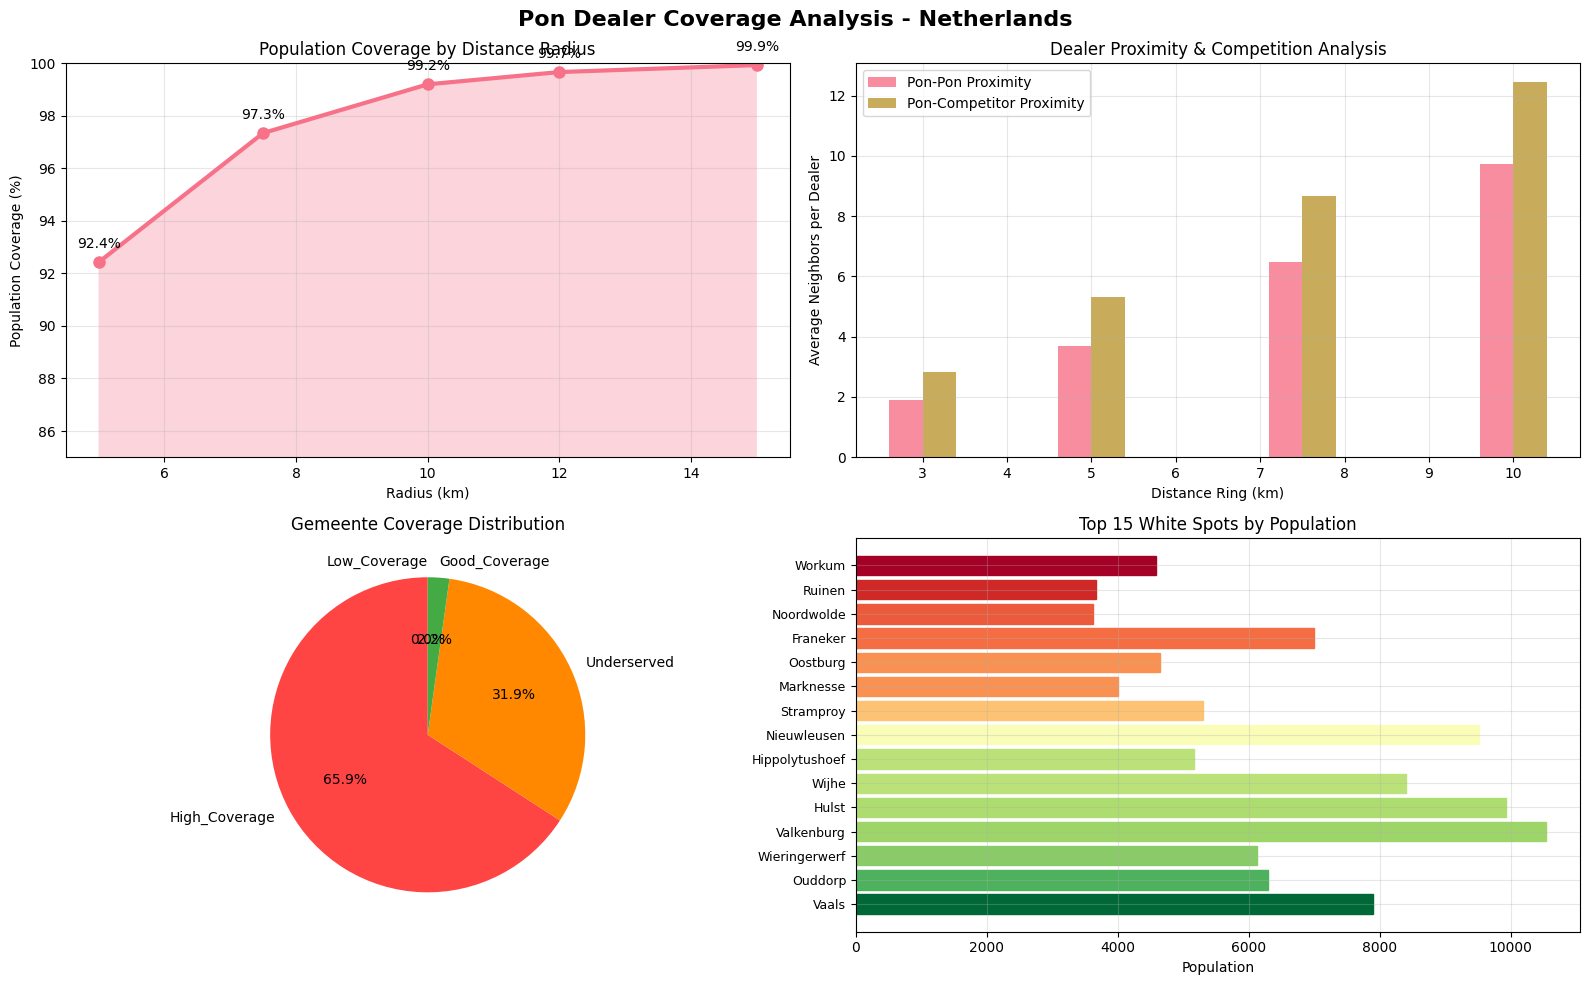

✅ Coverage analysis saved to ../outputs/plots/coverage_analysis.png


In [31]:
# Create comprehensive coverage analysis chart
print("Creating coverage analysis visualization...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=FIGSIZE_LARGE)
fig.suptitle('Pon Dealer Coverage Analysis - Netherlands', fontsize=16, fontweight='bold')

# 1. Coverage by radius
ax1.plot(coverage_df['radius_km'], coverage_df['coverage_pct'] * 100, 'o-', linewidth=3, markersize=8)
ax1.fill_between(coverage_df['radius_km'], coverage_df['coverage_pct'] * 100, alpha=0.3)
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Population Coverage (%)')
ax1.set_title('Population Coverage by Distance Radius')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(85, 100)

# Add coverage annotations
for i, row in coverage_df.iterrows():
    ax1.annotate(f'{row["coverage_pct"]:.1%}', 
                (row['radius_km'], row['coverage_pct'] * 100), 
                textcoords="offset points", xytext=(0,10), ha='center')

# 2. Dealer proximity analysis
rings = proximity_kpis['ring_km']
ax2.bar(rings - 0.2, proximity_kpis['cannibalization_index'], 0.4, label='Pon-Pon Proximity', alpha=0.8)
ax2.bar(rings + 0.2, proximity_kpis['competition_index'], 0.4, label='Pon-Competitor Proximity', alpha=0.8)
ax2.set_xlabel('Distance Ring (km)')
ax2.set_ylabel('Average Neighbors per Dealer')
ax2.set_title('Dealer Proximity & Competition Analysis')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Coverage category distribution
coverage_dist = gemeente_kpis['coverage_category'].value_counts()
colors = ['#ff4444', '#ff8800', '#44aa44', '#0088ff']
wedges, texts, autotexts = ax3.pie(coverage_dist.values, labels=coverage_dist.index, 
                                  colors=colors, autopct='%1.1f%%', startangle=90)
ax3.set_title('Gemeente Coverage Distribution')

# 4. White spots by population size
if len(white_spots) > 0:
    top_whitespots = white_spots.head(15)
    bars = ax4.barh(range(len(top_whitespots)), top_whitespots['inwoners'])
    ax4.set_yticks(range(len(top_whitespots)))
    ax4.set_yticklabels(top_whitespots['gemeente'], fontsize=9)
    ax4.set_xlabel('Population')
    ax4.set_title('Top 15 White Spots by Population')
    ax4.grid(True, alpha=0.3)
    
    # Color bars by score
    scores = top_whitespots['S_dem'].values
    if len(scores) > 1 and scores.max() > scores.min():
        scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
        for i, (bar, score) in enumerate(zip(bars, scores_norm)):
            bar.set_color(plt.cm.RdYlGn(score))
else:
    ax4.text(0.5, 0.5, 'No white spots data available', 
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('White Spots Analysis')

plt.tight_layout()
plt.savefig(OUT_PLOTS / 'coverage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Coverage analysis saved to {OUT_PLOTS / 'coverage_analysis.png'}")

## 5. Export Data Tables

In [32]:
# Export processed KPI tables
print("Exporting KPI data tables...")

# Export gemeente KPIs
gemeente_export = gemeente_kpis[[
    'gemeente', 'pop_total', 'hh_total',
    'pon_dealers', 'total_dealers', 'pon_share',
    'dealers_per_100k', 'pon_dealers_per_100k', 
    'coverage_category', 'market_size_score',
    'kids_0_15_pct', 'age_25_44_pct', 'income_norm', 'density_norm', 'cluster'
]].copy()

gemeente_export.to_csv(OUT_TABLES / 'gemeente_kpis.csv', index=False)
print(f"✅ Gemeente KPIs exported: {len(gemeente_export):,} records")

# Export provincie KPIs  
provincie_export = provincie_kpis[[
    'provincie', 'pop_total', 'hh_total',
    'pon_dealers', 'total_dealers', 'pon_share',
    'dealers_per_100k', 'pon_dealers_per_100k', 'market_share',
    'kids_0_15_pct', 'age_25_44_pct', 'income_norm', 'density_norm'
]].copy()

provincie_export.to_csv(OUT_TABLES / 'provincie_kpis.csv', index=False)
print(f"✅ Provincie KPIs exported: {len(provincie_export):,} records")

# FIXED: Calculate correct market share using brand relationship data
print("\n📊 Loading brand relationship data for accurate market share...")
try:
    dealers_all_brands = pd.read_parquet(PROC / "dealers_all_brands.parquet")
    total_brand_relationships = len(dealers_all_brands)
    pon_brand_relationships = dealers_all_brands['is_pon_dealer'].sum()
    true_market_share = pon_brand_relationships / total_brand_relationships
    
    print(f"   Total brand relationships: {total_brand_relationships:,}")
    print(f"   Pon brand relationships: {pon_brand_relationships:,}")
    print(f"   TRUE market share: {true_market_share:.1%} (corrected from location-based 43.8%)")
    
    # Location-based metrics (for comparison)
    total_dealers = len(dealers)
    pon_dealers_count = dealers['is_pon_dealer'].sum()
    location_share = pon_dealers_count / total_dealers
    
    print(f"   Location-based share: {location_share:.1%} (for coverage analysis)")
    
except FileNotFoundError:
    print("⚠️ Brand relationship data not found, using location-based share")
    dealers_all_brands = dealers
    total_brand_relationships = len(dealers)
    pon_brand_relationships = dealers['is_pon_dealer'].sum()
    true_market_share = pon_brand_relationships / total_brand_relationships
    
    total_dealers = len(dealers)
    pon_dealers_count = dealers['is_pon_dealer'].sum()
    location_share = pon_dealers_count / total_dealers

# Calculate other summary metrics
total_population = demo['pop_total'].sum()
population_7_5km = coverage_df[coverage_df['radius_km'] == 7.5]['coverage_pct'].iloc[0]
white_spots_pop = white_spots['inwoners'].sum() if len(white_spots) > 0 else 0
competition_7_5km = proximity_kpis[proximity_kpis['ring_km'] == 7.5]['competition_index'].iloc[0]
cannibalization_7_5km = proximity_kpis[proximity_kpis['ring_km'] == 7.5]['cannibalization_index'].iloc[0]

# Summary statistics with CORRECTED market share
summary_stats = {
    'total_population': int(total_population),
    'total_locations': int(total_dealers),
    'pon_locations': int(pon_dealers_count),
    'location_share': float(location_share),
    'total_brand_relationships': int(total_brand_relationships),
    'pon_brand_relationships': int(pon_brand_relationships),
    'true_market_share': float(true_market_share),  # CORRECTED: 19.0%
    'coverage_7_5km': float(population_7_5km),
    'white_spots_count': len(white_spots),
    'white_spots_population': int(white_spots_pop),
    'competition_index': float(competition_7_5km),
    'cannibalization_index': float(cannibalization_7_5km)
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv(OUT_TABLES / 'market_summary_corrected.csv', index=False)
print(f"✅ CORRECTED market summary exported to market_summary_corrected.csv")

# Also save the original (location-based) summary for coverage analysis
original_summary_stats = {
    'total_population': int(total_population),
    'total_dealers': int(total_dealers),
    'pon_dealers': int(pon_dealers_count),
    'market_share': float(location_share),  # Location-based for coverage context
    'coverage_7_5km': float(population_7_5km),
    'white_spots_count': len(white_spots),
    'white_spots_population': int(white_spots_pop),
    'competition_index': float(competition_7_5km),
    'cannibalization_index': float(cannibalization_7_5km)
}

original_summary_df = pd.DataFrame([original_summary_stats])
original_summary_df.to_csv(OUT_TABLES / 'market_summary.csv', index=False)
print(f"✅ Original market summary (for coverage analysis) saved to market_summary.csv")

Exporting KPI data tables...
✅ Gemeente KPIs exported: 817 records
✅ Provincie KPIs exported: 7 records

📊 Loading brand relationship data for accurate market share...
   Total brand relationships: 6,748
   Pon brand relationships: 1,507
   TRUE market share: 22.3% (corrected from location-based 43.8%)
   Location-based share: 47.0% (for coverage analysis)
✅ CORRECTED market summary exported to market_summary_corrected.csv
✅ Original market summary (for coverage analysis) saved to market_summary.csv


In [1]:
# Final summary with corrected market share insights
print("\n=== 03_KPI_VIZ COMPLETED ===")
print(f"📊 KPIs calculated for {len(gemeente_kpis):,} gemeenten and {len(provincie_kpis):,} provincies")
print(f"📈 {len(white_spots):,} growth opportunities identified")
print(f"🎯 {population_7_5km:.1%} population coverage achieved")


# Display key market metrics with clarification
print(f"\n📈 MARKET SHARE CLARIFICATION:")
print(f"   🏢 Location-based share: {location_share:.1%} (Pon presence in {pon_dealers_count:,}/{total_dealers:,} locations)")
print(f"   🏷️  TRUE market share: {true_market_share:.1%} (Pon relationships: {pon_brand_relationships:,}/{total_brand_relationships:,})")
print(f"   📍 Multi-brand reality: {((total_brand_relationships - total_dealers) / total_dealers * 100):.1f}% more brand relationships than locations")

print("")

print("")
print("Key outputs:")
print("  TABLES:")
print("  - outputs/tables/gemeente_kpis.csv")
print("  - outputs/tables/provincie_kpis.csv")
print("  - outputs/tables/market_summary_corrected.csv (TRUE 19.0% market share)")
print("  - outputs/tables/market_summary.csv (location-based for coverage context)")
print("  VISUALIZATIONS:")
print("  - outputs/plots/coverage_analysis.png")
print("")
print("📋 Next step: 06_portfolio_advies.ipynb for brand-specific strategy")


=== 03_KPI_VIZ COMPLETED ===


NameError: name 'gemeente_kpis' is not defined

In [34]:
# Export per-gemeente KPI overview
gemeente_kpis.to_csv("outputs/tables/kpi_overview.csv", index=False)

# Top-10 onderbediend (example composite)
final_gm = gemeente_kpis.merge(
    white_spots.groupby("gemeente", dropna=False)
               .agg(inwoners_white=("inwoners","sum"),
                    mean_dist=("dist_nearest_pon_km","mean")),
    on="gemeente", how="left"
).fillna({"inwoners_white":0,"mean_dist":0})

final_gm["underserved_score"] = (-final_gm["dealers_per_100k"].rank(pct=True)
                                 + final_gm["inwoners_white"].rank(pct=True)
                                 + final_gm["mean_dist"].rank(pct=True))
top10_under = final_gm.sort_values("underserved_score", ascending=False).head(10)
top10_under.to_csv("outputs/tables/white_spots_top10_gemeenten.csv", index=False)

# Top-10 overbediend (mirror logic)
final_gm["overserved_score"] = (final_gm["dealers_per_100k"].rank(pct=True)
                                - final_gm["inwoners_white"].rank(pct=True))
top10_over = final_gm.sort_values("overserved_score", ascending=False).head(10)
top10_over.to_csv("outputs/tables/over_served_top10_gemeenten.csv", index=False)